In [1]:
import pandas as pd
from river import compose
from river import linear_model
from river import metrics
from river import preprocessing
from river import stream
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
import numpy as np
from river import evaluate
from river import optim
import datetime as dt

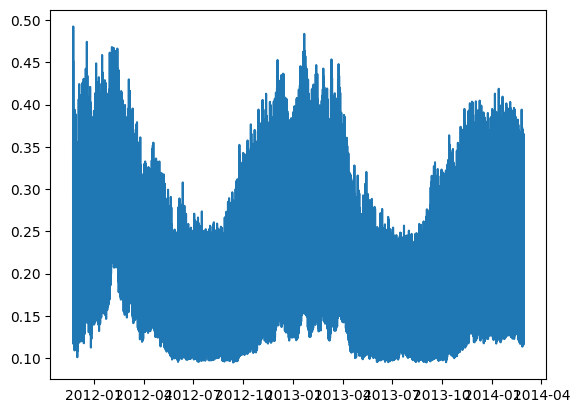

In [2]:
# Load the data
df = pd.read_csv('merged_data.csv')


# Convert the 'utc_timestamp' column to datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Drop the first row
df = df.dropna()

df['day_of_week'] = df['DateTime'].dt.dayofweek
df['hour_of_day'] = df['DateTime'].dt.hour
df['month'] = df['DateTime'].dt.month

df

#plot the data
plt.plot(df['DateTime'], df['MeanEnergyConsumption'])

In [3]:
#save the last week into a separate dataframe
df_last_week = df[-168:]
df = df[:-168]

print(df_last_week['DateTime'].max())
print(df['DateTime'].max())


2014-02-28 00:00:00
2014-02-21 00:00:00


In [4]:
#df['MeanEnergyConsumption'].plot()

#drop the utc_timestamp column
#df = df.drop('utc_timestamp', axis=1)

stream = iter(df.itertuples(index=False))
stream = iter([(x._asdict(), y) for x, y in zip(df.drop('MeanEnergyConsumption', axis=1).itertuples(index=False), df['MeanEnergyConsumption'])])




Final error: 0.2530602714279364
Predictions: [-1.8471870419002647, -1.0304106686736698, -0.2648351902760292, -1.4630165891430795, -1.3260990010488716, -1.5337111988586443, -1.0784411257244735, -0.3703660710568947, -0.2257539350941166, -0.13220030606778743, 0.1618603603013969, -0.3979843781020547, -0.30741441483908105, -0.19987689429529895, -0.01797960534586458, 0.25988167205672613, 0.29549161410840774, 0.8284127850459229, 1.323575119716033, 0.9725849585676648, 0.7445993993544718, 0.7142215831553969, 0.4261715415940651, 0.3854281211747125, 0.04079332496314306, -0.3158684027148936, -0.3554559064883836, -1.0829496985925362, -1.0856818945784437, -1.1601564775790585, -0.9933646312904783, -0.5611648796754977, -0.47634739707056717, -0.6097693887655827, -0.8965940858957123, -1.0887932903921826, -0.9505457308697312, -0.7298478592129258, 0.03000829426456385, 0.3883345680235676, 0.42152536600593243, 0.3918156080230438, 0.3507393294220147, 0.10263800512981416, 0.32175611514319485, 0.53677965112098

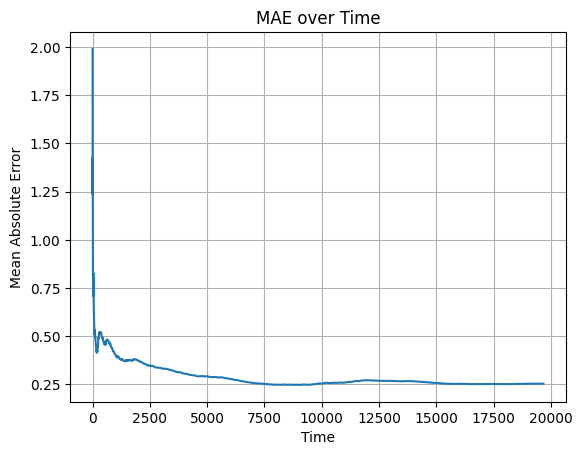

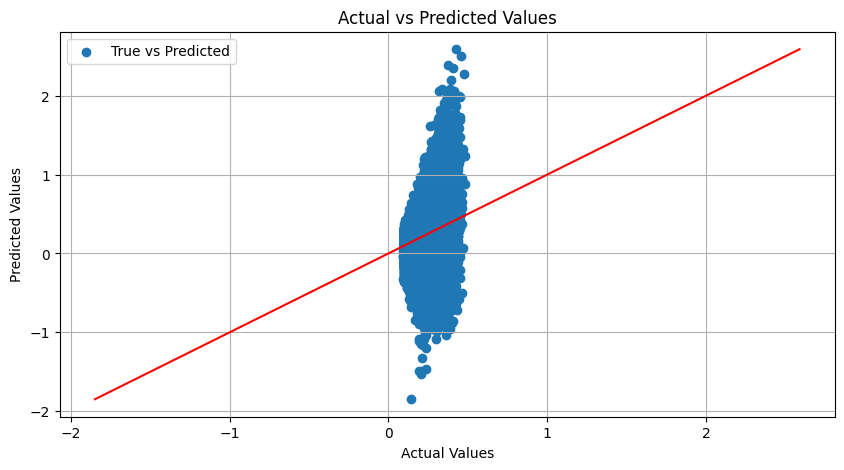

In [6]:
import matplotlib.pyplot as plt
from river import time_series

model = time_series.HoltWinters(
    alpha=0.3,
    beta=0.1,
    gamma=0.5,
    seasonality=24,
    multiplicative=True,
)

metric = metrics.MAE()

# Create a list to store the predictions and errors
predictions = []
errors = []
actuals = []

# Assuming 'df' is your DataFrame and 'MeanEnergyConsumption' is what you want to predict
for i, (_, row) in enumerate(df.iterrows()):
    y = row['MeanEnergyConsumption']
    model.learn_one(y)

    # Predict the next point only after the model has been trained on 'seasonality' number of data points
    if i >= model.seasonality:
        prediction = model.forecast(horizon=24*7)[24*7-1]
        predictions.append(prediction)  # Store the prediction
        actuals.append(y)  # Store the actual value

        # Update the metric
        metric.update(y, prediction)
        errors.append(metric.get())  # Store the error

print(f"Final error: {metric.get()}")
print(f"Predictions: {predictions}")

# Plot the MAE over time
plt.plot(errors)
plt.xlabel('Time')
plt.ylabel('Mean Absolute Error')
plt.title('MAE over Time')
plt.grid(True)
plt.show()

# Scatter plot of the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(actuals, predictions, label='True vs Predicted')

# Add a red line for perfect predictions
min_val = min(min(actuals), min(predictions))
max_val = max(max(actuals), max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
from river import metrics
from river import time_series
import pandas as pd

# Assuming you have your model and DataFrame defined as before

model = time_series.HoltWinters(
    alpha=0.3,
    beta=0.1,
    gamma=0.5,
    seasonality=24,
    multiplicative=True
)

metric = metrics.MAE()

# Assuming df is your DataFrame and 'target' is the column you want to predict
y_true = df['MeanEnergyConsumption'].values
print(y_true)
# Define the number of splits for the cross-validation
n_splits = 5

# Calculate the size of each split
split_size = len(y_true) // n_splits
print(split_size)

# Initialize an empty list to store the errors
errors = []

# Loop over the splits
for i in range(n_splits):
    # Define the training and test sets
    train_y = y_true[:i*split_size]
    test_y = y_true[i*split_size:(i+1)*split_size]
    
    # Loop over the training set
    for y in train_y:
        # Update the model
        model.learn_one(y)
    
    # Loop over the test set
    for y in test_y:
        # Make a prediction only if the model has seen at least one full season of data
        if i*split_size >= model.seasonality:
            y_pred = model.forecast(horizon=24)[0]
            
            # Update the error metric
            metric.update(y, y_pred)
    
    # Store the error
    print(metric.get())
    errors.append(metric.get())

# Print the errors
print(errors)

[0.355      0.1745     0.134      ... 0.30078433 0.25387251 0.22993701]
3939
[0.0, 0.06445350345931337, 0.07557308147127642, 0.10277372403915536, 0.09305564382946072]


19672


C:\Users\Stijn\AppData\Local\Temp\ipykernel_2096\2192244862.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(data['DateTime'], data['MeanEnergyConsumption'], linestyle='-', marker=None,alpha=0.5, label='Actual Values')
C:\Users\Stijn\AppData\Local\Temp\ipykernel_2096\2192244862.py:18: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(predictions_df['DateTime'], predictions_df['Predictions'], linestyle='-', marker=None, alpha=0.5,label='Predictions')


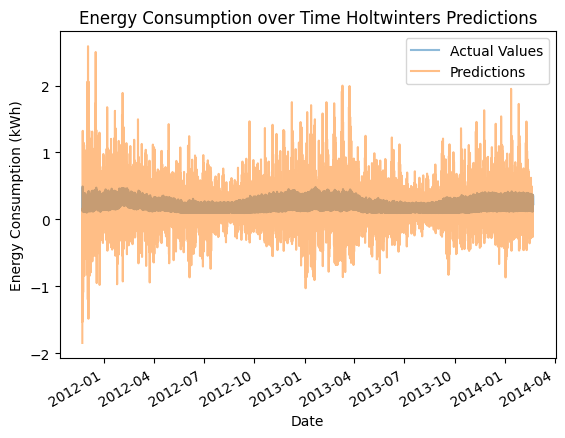

C:\Users\Stijn\AppData\Local\Temp\ipykernel_2096\2192244862.py:38: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(data['DateTime'], data['MeanEnergyConsumption'], linestyle='-', marker=None,alpha=0.5, label='Actual Values')
C:\Users\Stijn\AppData\Local\Temp\ipykernel_2096\2192244862.py:39: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(predictions_df['DateTime'], predictions_df['Predictions'], linestyle='-', marker=None, alpha=0.5,label='Predictions')


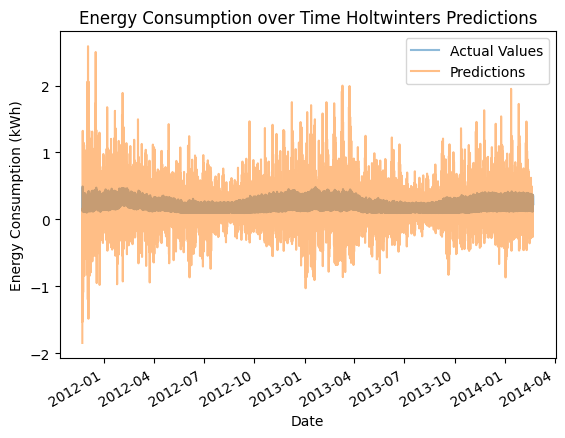

19672
19696


ValueError: x and y must be the same size

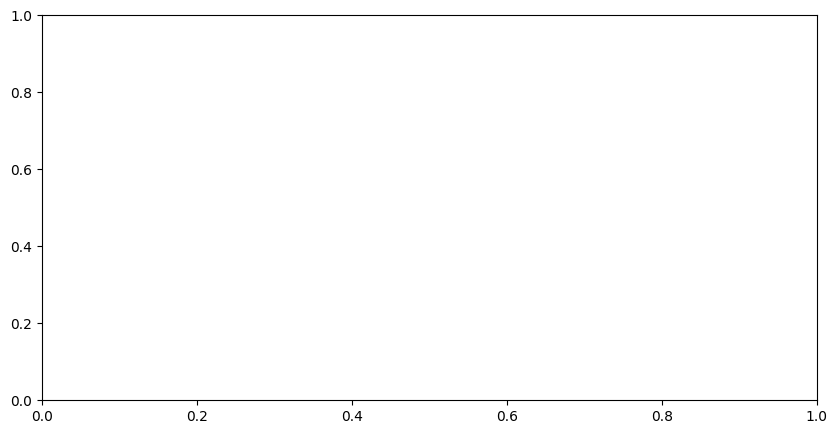

In [8]:
#from matplotlib import pyplot as plt

# Define the start and end dates for the data
start_date = df['DateTime'].min()
end_date = df['DateTime'].max()
print(len(predictions))

# Filter the data for the entire period
data = df[(df['DateTime'] >= start_date) & (df['DateTime'] <= end_date)]

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame(predictions, columns=['Predictions'])
predictions_df['DateTime'] = data['DateTime']

# Plot the actual values and predictions
fig, ax = plt.subplots()
ax.plot_date(data['DateTime'], data['MeanEnergyConsumption'], linestyle='-', marker=None,alpha=0.5, label='Actual Values')
ax.plot_date(predictions_df['DateTime'], predictions_df['Predictions'], linestyle='-', marker=None, alpha=0.5,label='Predictions')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Energy Consumption over Time Holtwinters Predictions')

# Rotate date labels automatically
fig.autofmt_xdate()

plt.show()


data = df[(df['DateTime'] >= start_date) & (df['DateTime'] <= end_date)]

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame(predictions, columns=['Predictions'])
predictions_df['DateTime'] = data['DateTime']

# Plot the actual values and predictions
fig, ax = plt.subplots()
ax.plot_date(data['DateTime'], data['MeanEnergyConsumption'], linestyle='-', marker=None,alpha=0.5, label='Actual Values')
ax.plot_date(predictions_df['DateTime'], predictions_df['Predictions'], linestyle='-', marker=None, alpha=0.5,label='Predictions')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Energy Consumption over Time Holtwinters Predictions')

# Rotate date labels automatically
fig.autofmt_xdate()

plt.show()
print(len(predictions))
print(len(data['MeanEnergyConsumption']))
# Scatter plot of the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(data['MeanEnergyConsumption'], predictions_df['Predictions'], label='True vs Predicted')

# Add a red line for perfect predictions
min_val = min(min(data['MeanEnergyConsumption']), min(predictions_df['Predictions']))
max_val = max(max(data['MeanEnergyConsumption']), max(predictions_df['Predictions']))
plt.plot([min_val, max_val], [min_val, max_val], color='red')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.legend()
plt.show()



19696
19672
19672
19672


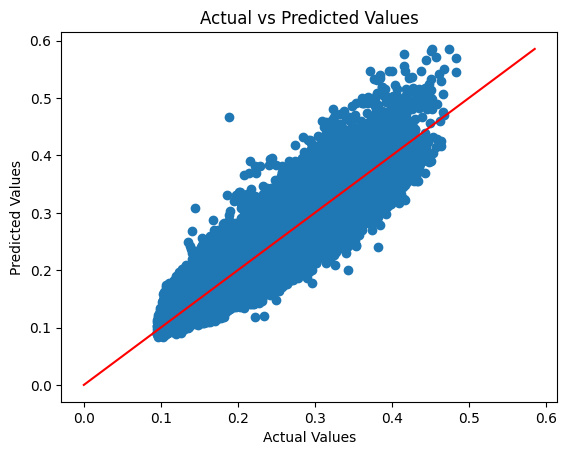

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot
length = len(df['MeanEnergyConsumption'])
print(length)
print(len(predictions))

diff = length - len(predictions)
#copy df to a new dataframe that drops the first row
df_new = df[diff:]


print(len(predictions))
print(len(df_new['MeanEnergyConsumption']))

plt.scatter(df_new['MeanEnergyConsumption'], predictions)

# Create a 45 degree line
max_value = max(max(df_new['MeanEnergyConsumption']), max(predictions))
plt.plot([0, max_value], [0, max_value], color='red')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

plt.show()

In [ ]:
from river import datasets
from river import metrics
from river import time_series



model = time_series.HoltWinters(
    alpha=0.3,
    beta=0.1,
    gamma=0.5,
    seasonality=24,
    multiplicative=True
)

metric = metrics.MAE()

time_series.evaluate(
    stream,
    model,
    metric,
    horizon=24*7
)



+1   MAE: 0.028389
+2   MAE: 0.031481
+3   MAE: 0.03436
+4   MAE: 0.03684
+5   MAE: 0.038819
+6   MAE: 0.040192
+7   MAE: 0.041114
+8   MAE: 0.041852
+9   MAE: 0.042814
+10  MAE: 0.043982
+11  MAE: 0.045383
+12  MAE: 0.046899
+13  MAE: 0.048577
+14  MAE: 0.050306
+15  MAE: 0.05179
+16  MAE: 0.052923
+17  MAE: 0.053558
+18  MAE: 0.053653
+19  MAE: 0.05312
+20  MAE: 0.051762
+21  MAE: 0.049839
+22  MAE: 0.047848
+23  MAE: 0.046559
+24  MAE: 0.046685
+25  MAE: 0.050598
+26  MAE: 0.055215
+27  MAE: 0.059645
+28  MAE: 0.063643
+29  MAE: 0.066937
+30  MAE: 0.069316
+31  MAE: 0.070623
+32  MAE: 0.071448
+33  MAE: 0.072354
+34  MAE: 0.073397
+35  MAE: 0.074626
+36  MAE: 0.076128
+37  MAE: 0.077853
+38  MAE: 0.079873
+39  MAE: 0.082013
+40  MAE: 0.084201
+41  MAE: 0.086249
+42  MAE: 0.087662
+43  MAE: 0.08835
+44  MAE: 0.088171
+45  MAE: 0.086938
+46  MAE: 0.085083
+47  MAE: 0.08341
+48  MAE: 0.082649
+49  MAE: 0.084583
+50  MAE: 0.088477
+51  MAE: 0.09274
+52  MAE: 0.096787
+53  MAE: 0.100357


In [ ]:
#print the last values of the actual data
print(df['DateTime'][-24*7:])


19528   2014-02-14 01:00:00
19529   2014-02-14 02:00:00
19530   2014-02-14 03:00:00
19531   2014-02-14 04:00:00
19532   2014-02-14 05:00:00
                ...        
19691   2014-02-20 20:00:00
19692   2014-02-20 21:00:00
19693   2014-02-20 22:00:00
19694   2014-02-20 23:00:00
19695   2014-02-21 00:00:00
Name: DateTime, Length: 168, dtype: datetime64[ns]


168
168
168


C:\Users\Stijn\AppData\Local\Temp\ipykernel_6996\2516155532.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Hoursrange = pd.date_range(start_date, end_date, freq='H')
C:\Users\Stijn\AppData\Local\Temp\ipykernel_6996\2516155532.py:31: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(mdates.date2num(week_data['DateTime']), week_data['MeanEnergyConsumption'], linestyle='-', marker=None, label='Actual Values')
C:\Users\Stijn\AppData\Local\Temp\ipykernel_6996\2516155532.py:34: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(mdates.date2num(week_predictions['DateTime']), week_predictions['Predictions'], linestyle='-', marker=None, label='Predictions')


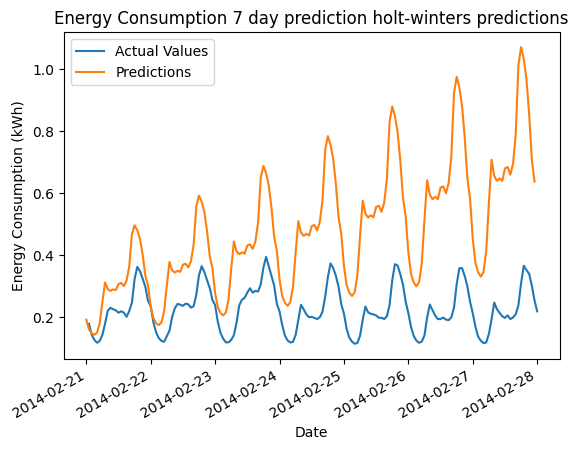

In [ ]:
import matplotlib.dates as mdates

# Generate predictions
predictions = model.forecast(horizon=24*7)

# Get the start and end date for the last week of data
start_date = df_last_week['DateTime'].max() - pd.DateOffset(weeks=1)
end_date = df_last_week['DateTime'].max()

print(len(predictions))
print(len(df_last_week['DateTime']))


# Generate date range for the predictions
end_data_predictions = end_date + pd.DateOffset(hours=24*7)-pd.DateOffset(hours=1)
Hoursrange = pd.date_range(start_date, end_date, freq='H')
#drop one hour from the end of the range
Hoursrange = Hoursrange[:-1]
print(len(Hoursrange))

# Create a DataFrame for the predictions
week_predictions = pd.DataFrame({'DateTime': Hoursrange, 'Predictions': predictions})

# Filter the data for the last week
week_data = df_last_week

# Plot the actual values and predictions
fig, ax = plt.subplots()

# Plot the actual values
ax.plot_date(mdates.date2num(week_data['DateTime']), week_data['MeanEnergyConsumption'], linestyle='-', marker=None, label='Actual Values')

# Plot the predictions
ax.plot_date(mdates.date2num(week_predictions['DateTime']), week_predictions['Predictions'], linestyle='-', marker=None, label='Predictions')

# Label the axes and add a legend
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_xlabel('Date')
ax.legend()

# Add a title
ax.set_title('Energy Consumption 7 day prediction holt-winters predictions')

# Rotate date labels automatically
fig.autofmt_xdate()

plt.show()

[0.19131968697675483, 0.1598037910952273, 0.1474123878665561, 0.14227296879089885, 0.1493335975853246, 0.1795466430237712, 0.2483326164674972, 0.31123336489289405, 0.2895089445600489, 0.2840760352724211, 0.2890201803166636, 0.2866120070944429, 0.3062268582365391, 0.3095512479802212, 0.29972911108292766, 0.317337877914243, 0.36172115218003875, 0.46643827638461666, 0.4958477744013202, 0.47970448564994705, 0.45174570181124946, 0.4008620727408866, 0.3336671278551012, 0.30100647116662216, 0.23458716031101282, 0.1956064879764248, 0.18013344173680487, 0.1735638277060538, 0.18187909248131656, 0.21832458146401132, 0.3014883895266487, 0.3772641736287752, 0.3503925254338391, 0.3432981456785473, 0.34875413927482957, 0.3453424897665142, 0.3684454513742578, 0.37191730857689814, 0.35961357001255295, 0.3802170286426164, 0.43280776368444174, 0.5573597286263572, 0.5917232374360757, 0.5717172333199199, 0.5377086109787343, 0.4765422605787241, 0.39616967118030777, 0.35695434534694376, 0.2778546336452708, 0

C:\Users\Stijn\AppData\Local\Temp\ipykernel_6996\111228305.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Hoursrange = pd.date_range(end_date, end_data_predictions, freq='H')
C:\Users\Stijn\AppData\Local\Temp\ipykernel_6996\111228305.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  week_data = df[(df_last_week['DateTime'] >= start_date) & (df_last_week['DateTime'] < end_date)]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

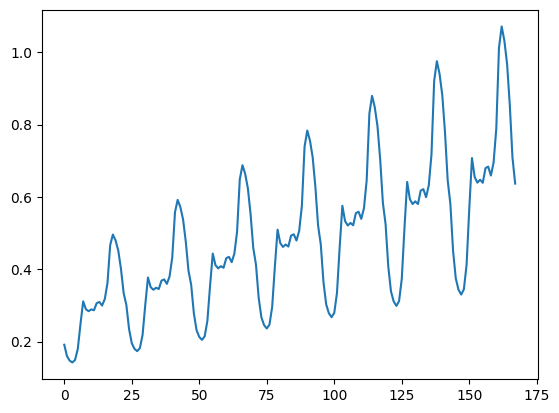

In [ ]:
# Assume `model` is your trained HoltWinters model
# and `x_last` is the last known data point

import matplotlib.dates as mdates

predictions = model.forecast(horizon=24*7)

print(predictions)

# Plot the predictions
plt.plot(predictions)



start_date = pd.to_datetime('2014-02-14 00:00:00')
end_date = start_date + pd.DateOffset(weeks=1)

end_data_predictions = end_date + pd.DateOffset(hours=24*7)-pd.DateOffset(hours=1)

Hoursrange = pd.date_range(end_date, end_data_predictions, freq='H')
print(len(Hoursrange))
print(len(predictions))

#extract hours timestamps from the predictions
week_predictions = pd.DataFrame({'DateTime': Hoursrange, 'Predictions': predictions})



df['DateTime'] = pd.to_datetime(df['DateTime'])

# Filter the data
week_data = df[(df_last_week['DateTime'] >= start_date) & (df_last_week['DateTime'] < end_date)]

#combine the predictions and timestamps into a dataframe


fig, ax = plt.subplots()

# Also plot the actual values with transparency and a label for the legend
ax.plot_date(mdates.date2num(week_data['DateTime']), week_data['MeanEnergyConsumption'], linestyle='-', marker=None, label='Actual Values')

# Plot the predictions with transparency and a label for the legend
ax.plot_date(mdates.date2num(week_predictions['DateTime']), week_predictions['Predictions'], linestyle='-', marker=None, label='Predictions')

# Label the y-axis
ax.set_ylabel('Energy Consumption (kWh)')
# Set the x-axis label
ax.set_xlabel('Date')
# Add a legend
ax.legend()
#add title
ax.set_title('Energy Consumption 7 day prediction holt-winters predictions')

# Rotate date labels automatically
fig.autofmt_xdate()

plt.show()


In [ ]:
from river import optim
from river import evaluate
from sklearn.model_selection import ParameterGrid
from river import datasets
from river import metrics
from river import time_series

stream = iter(df.itertuples(index=False))
stream = iter([(x._asdict(), y) for x, y in zip(df.drop('MeanEnergyConsumption', axis=1).itertuples(index=False), df['MeanEnergyConsumption'])])
# Define the parameter grid

learning_rate = [1,2,0.5,4,10,0.1]
NumberofNeighbeurs = [16,18,20]

param_grid = {'alpha': [0.3,0.1,0.2,0.4,0.5],
              'beta': [0.1,0.3,0.2,0.4,0.5],
              'gamma': [0.5,0.3,0.2,0.4,0.1],               
              }

# Initialize the best MAE and learning rate
best_mae = float('inf')
best_lr = None


ListOfListOfPredictions = []
listofParams = []
# Iterate over the parameter grid
for params in ParameterGrid(param_grid):
    print(f'params: {params}')
    # Create a new model with the current learning rate
    model = time_series.HoltWinters(
        alpha=params['alpha'],
        beta=params['beta'],
        gamma=params['gamma'],
        seasonality=24,
        multiplicative=True
    )

    metric = metrics.MAE()

    steps = time_series.evaluate(
        stream,
        model,
        metric,
        horizon=24*7
    )

    predictions = model.forecast(horizon=24*7)
    print(steps.get()[-1])


    stream = iter(df.itertuples(index=False))
    stream = iter([(x._asdict(), y) for x, y in zip(df.drop('MeanEnergyConsumption', axis=1).itertuples(index=False), df['MeanEnergyConsumption'])])
    
    # Initialize lists to store the predictions and their timestamps
        
    ListOfListOfPredictions.append(predictions)
    listofParams.append(params)

    # If the current MAE is better than the best MAE, update the best MAE and learning rate
    lastMean = steps.get()[-1]
    
    if lastMean != 0 and lastMean < best_mae:
        best_mae = lastMean
        best_alpha = params['alpha']
        best_beta = params['beta']
        best_gamma = params['gamma']
        
print(f'Best MAE: {best_mae}')
print(f'Best alpha: {best_alpha}')
print(f'Best beta: {best_beta}')
print(f'Best gamma: {best_gamma}')


#plotting of the predictions and actual values for a week

start_date =  df['DateTime'].min()
end_date =  df['DateTime'].max()
# Initialize lists to store the predictions and their timestamps
predictions = []
timestamps = pd.date_range(start=start_date, end=end_date, freq='1h')

for predictions,params in zip(ListOfListOfPredictions,listofParams):
    # Define the start and end dates
    start_date = pd.to_datetime('2013-01-01')
    end_date = start_date + pd.DateOffset(weeks=1)
    df['DateTime'] = pd.to_datetime(df['DateTime'])

    # Filter the data
    week_data = df[(df['DateTime'] >= start_date) & (df['DateTime'] < end_date)]

    #combine the predictions and timestamps into a dataframe
    df_prediction = pd.DataFrame({'DateTime': timestamps, 'Predictions': predictions})

    #convert datetime to datetime object
    df_prediction['DateTime'] = pd.to_datetime(df_prediction['DateTime'])
    week_predictions = df_prediction[(df_prediction['DateTime'] >= start_date) & (df_prediction['DateTime'] < end_date)]
    fig, ax = plt.subplots()

    # Also plot the actual values with transparency and a label for the legend
    ax.plot_date(mdates.date2num(week_data['DateTime']), week_data['MeanEnergyConsumption'], linestyle='-', marker=None, label='Actual Values')

    # Plot the predictions with transparency and a label for the legend
    ax.plot_date(mdates.date2num(week_predictions['DateTime']), week_predictions['Predictions'], linestyle='-', marker=None, label='Predictions')
    ax.set_ylabel('Energy Consumption (kWh)')
    ax.set_xlabel('Date')
    ax.legend()
    ax.set_title(f'{params["n_neighbors"]} KNN with {params["Aggregation_method"]}, {params["scaler"]}')

    # Rotate date labels automatically
    fig.autofmt_xdate()

    plt.show()





params: {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.5}
0.25645053574023985
params: {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.3}
0.2072314765083458
params: {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.2}
0.19661338183009666
params: {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.4}
0.22104609848747966
params: {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.1}
0.20900890189506954
params: {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.5}
168.8093886788002
params: {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.3}


KeyboardInterrupt: 